In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Definir la carpeta donde están los archivos CSV
folder_path = 'Data/'

# Definir los nombres de los archivos de los activos
assets = ['BBVA.MC', 'ELE.MC', 'ENG.MC', 'IBE.MC', 'LOG.MC']

# Leer y combinar los datos de los activos en un solo DataFrame
dfs = []
for asset in assets:
    file_path = folder_path + asset + '.csv'
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df.rename(columns={'Close': asset}, inplace=True)
    dfs.append(df[asset])

# Combinar todos los DataFrames en uno solo usando unión externa (outer join) por fecha
df = pd.concat(dfs, axis=1, join='outer')

# Mostrar las primeras filas del DataFrame combinado para verificar
print(df.head())

            BBVA.MC     ELE.MC     ENG.MC  IBE.MC     LOG.MC
Date                                                        
2023-06-22    6.732  20.950001  17.830000  11.755  24.040001
2023-06-23    6.652  20.850000  17.715000  11.675  24.180000
2023-06-26    6.748  21.110001  17.735001  11.660  24.000000
2023-06-27    6.784  21.340000  17.865000  11.790  24.180000
2023-06-28    6.854  21.450001  18.014999  11.870  24.480000


In [3]:
# Calcular los rendimientos diarios y la matriz de varianza-covarianza
returns = df.pct_change().dropna()
cov_matrix = returns.cov()

# Mostrar la matriz de varianza-covarianza
print("Matriz de Varianza-Covarianza:")
print(cov_matrix)

Matriz de Varianza-Covarianza:
          BBVA.MC    ELE.MC    ENG.MC    IBE.MC    LOG.MC
BBVA.MC  0.000240  0.000029  0.000027  0.000041  0.000052
ELE.MC   0.000029  0.000165  0.000064  0.000075  0.000023
ENG.MC   0.000027  0.000064  0.000140  0.000066  0.000025
IBE.MC   0.000041  0.000075  0.000066  0.000114  0.000024
LOG.MC   0.000052  0.000023  0.000025  0.000024  0.000092


In [4]:
# Definir los rendimientos esperados de cada activo
expected_returns = np.array([0.01, 0.02, 0.03, 0.04, 0.05])

# Restricciones
n_assets = len(expected_returns)

# Función objetivo y restricciones
def minimize_risk(weights):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights):
    return np.dot(weights, expected_returns)

# Restricciones
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Restricción de que los pesos sumen 1
        {'type': 'eq', 'fun': lambda x: portfolio_return(x) - 0.04})  # Rendimiento esperado mínimo de 4%

# Limitaciones de peso (entre 0 y 1)
bounds = tuple((0, 1) for asset in range(n_assets))

# Ejecutar la optimización
initial_weights = np.array([1 / n_assets] * n_assets)  # Distribución inicial de pesos
optimal_result = minimize(minimize_risk, initial_weights, method='SLSQP', bounds=bounds, constraints=cons)

# Mostrar los resultados
print("\nPesos óptimos:")
print(optimal_result.x)
print("Rendimiento esperado de la cartera óptima:")
print(portfolio_return(optimal_result.x))
print("Riesgo (varianza) de la cartera óptima:")
print(optimal_result.fun)


Pesos óptimos:
[2.99050199e-06 1.00001258e-01 1.99999477e-01 2.99985310e-01
 4.00010964e-01]
Rendimiento esperado de la cartera óptima:
0.039999999990683655
Riesgo (varianza) de la cartera óptima:
5.8802442236026327e-05


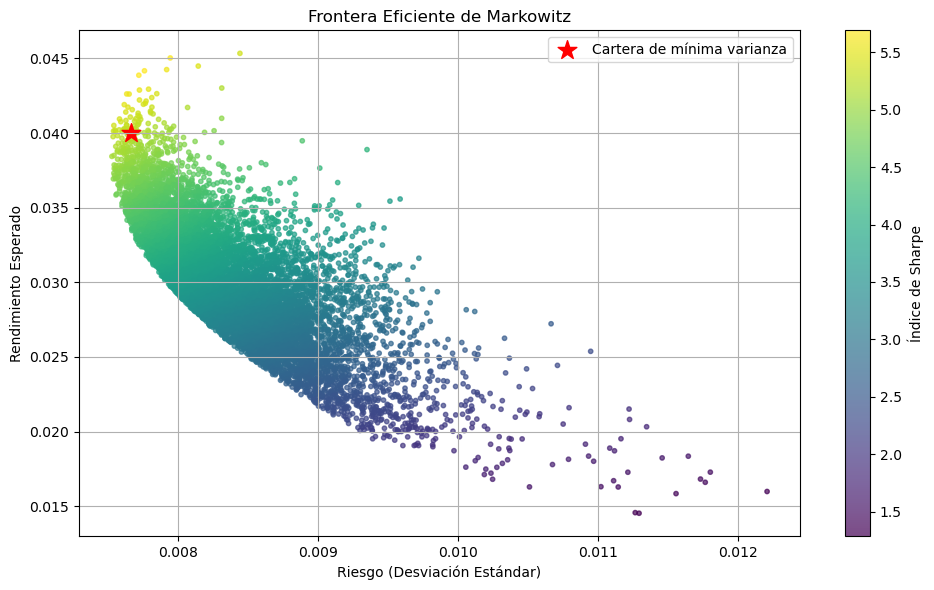

In [5]:
# Generar carteras aleatorias
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # Matriz para almacenar rendimiento, riesgo y pesos

for i in range(num_portfolios):
    weights = np.random.rand(n_assets)
    weights /= np.sum(weights)  # Normalizar para asegurar que sumen 1
    
    # Rendimiento y riesgo de la cartera
    portfolio_return_i = portfolio_return(weights)
    portfolio_risk_i = np.sqrt(minimize_risk(weights))
    
    # Guardar resultados
    results[0, i] = portfolio_return_i
    results[1, i] = portfolio_risk_i
    results[2, i] = portfolio_return_i / portfolio_risk_i

# Obtener la cartera de mínima varianza
min_var_portfolio_return = portfolio_return(optimal_result.x)
min_var_portfolio_risk = np.sqrt(optimal_result.fun)

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.7)
plt.colorbar(label='Índice de Sharpe')
plt.scatter(min_var_portfolio_risk, min_var_portfolio_return, marker='*', color='r', s=200, label='Cartera de mínima varianza')
plt.title('Frontera Eficiente de Markowitz')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Rendimiento Esperado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()